Loading results C++...
Regims identification :
  🟢 Bull Market (Regim 0) - Vol: 0.0048
  🟠 Bear Market (Regim 1) - Vol: 0.0094
  🔴 Crash Market (Regim 2) - Vol: 0.0214


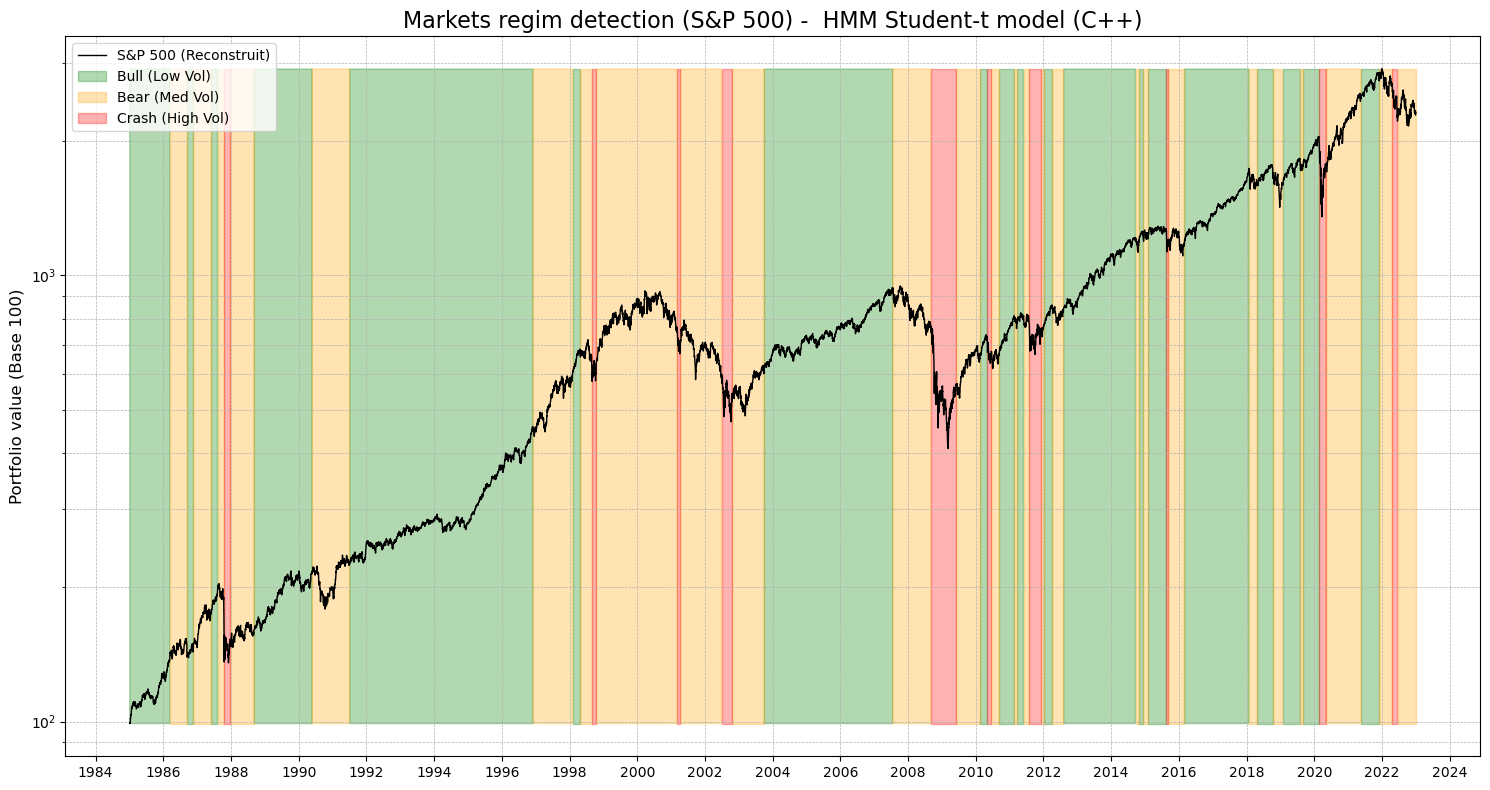

Graphique sauvegardé sous 'resultats_regimes.png'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 1. Chargement des données
print("Loading results C++...")
# Les dates avaient été sauvegardées par le premier script Python
dates = pd.read_csv("input_dates.csv", header=None, names=["Date"])
results = pd.read_csv("output_results.csv")

# Fusionner les dates et les résultats
df = pd.concat([dates, results], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2. Reconstruction du Prix (Cumul des Log-Rendements)
# On part d'une base 100
df['Cumulative_Return'] = 100 * np.exp(df['Observation'].cumsum())

# 3. Identification Automatique des Régimes (Car l'ordre 0,1,2 peut changer)
# On calcule la volatilité moyenne par index de régime trouvé par le C++
regime_stats = df.groupby('Regim_Viterbi')['Vol_Regim'].mean().sort_values()

# Le régime avec la plus faible Vol est "Bull", le plus haut est "Crash"
bull_idx = regime_stats.index[0]  # Volatilité min
bear_idx = regime_stats.index[1]  # Volatilité moyenne
crash_idx = regime_stats.index[2] # Volatilité max

print(f"Regims identification :")
print(f"  🟢 Bull Market (Regim {bull_idx}) - Vol: {regime_stats[bull_idx]:.4f}")
print(f"  🟠 Bear Market (Regim {bear_idx}) - Vol: {regime_stats[bear_idx]:.4f}")
print(f"  🔴 Crash Market (Regim {crash_idx}) - Vol: {regime_stats[crash_idx]:.4f}")

# 4. Création du Graphique "Money Shot"
fig, ax = plt.subplots(figsize=(15, 8))

# Tracer la courbe de prix en noir (fine)
ax.plot(df.index, df['Cumulative_Return'], color='black', linewidth=1, label='S&P 500 (Reconstruit)')

# Colorier le fond selon le régime
# On utilise fill_between pour colorier les zones
y_min, y_max = df['Cumulative_Return'].min(), df['Cumulative_Return'].max()

# On crée des masques pour chaque régime
is_bull = df['Regim_Viterbi'] == bull_idx
is_bear = df['Regim_Viterbi'] == bear_idx
is_crash = df['Regim_Viterbi'] == crash_idx

# Astuce pour remplir : on remplit par blocs de dates contiguës
# (C'est un peu technique pour que ce soit joli, on utilise une méthode simple ici : barres verticales fines)
# Pour un rendu parfait, on colore bande par bande
import matplotlib.collections as mcoll

def plot_regime_background(mask, color, label):
    # On trouve les changements d'état pour créer des blocs
    idx = df.index[mask]
    if len(idx) > 0:
        # On triche un peu en élargissant chaque point pour couvrir tout le graphe
        ax.fill_between(df.index, y_min, y_max, where=mask, 
                        color=color, alpha=0.3, label=label, step='mid')

plot_regime_background(is_bull, 'green', 'Bull (Low Vol)')
plot_regime_background(is_bear, 'orange', 'Bear (Med Vol)')
plot_regime_background(is_crash, 'red', 'Crash (High Vol)')

# Mise en forme
ax.set_title('Markets regim detection (S&P 500) -  HMM Student-t model (C++)', fontsize=16)
ax.set_ylabel('Portfolio value (Base 100)', fontsize=12)
ax.set_yscale('log') # Échelle log souvent préférable sur longue période
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Formatage des dates
ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Tous les 2 ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig("resultats_regimes.png", dpi=300)
plt.show()

print("Graphique sauvegardé sous 'resultats_regimes.png'.")